In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq
from evaluate import load
from seq2seq__utils import create_transformers_train_data, decode_with_transformer, train_transformer

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
data = pd.read_csv('../../data/yelp/test_en_parallel.txt', sep='\t', header=None)
data = data[[0, 1]]
data.columns = ['NEG', 'POS']

print(f"Total pairs: {len(data)}")
data.head()

Total pairs: 1001


,NEG,POS
0,Style 1,Style 2
1,ever since joes has changed hands it's just go...,Ever since joes has changed hands it's gotten ...
2,there is definitely not enough room in that pa...,There is so much room in that part of the venue
3,so basically tasted watered down.,It didn't taste watered down at all.
4,she said she'd be back and disappeared for a f...,"She said she'd be back, and didn't disappear a..."


In [5]:
neg_sentences = data['NEG'].values
pos_sentences = data['POS'].values

X_train, X_temp, y_train, y_temp = train_test_split(
    neg_sentences, pos_sentences, test_size=0.2, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(f"Train pairs: {len(X_train)}")
print(f"Validation pairs: {len(X_val)}")
print(f"Test pairs: {len(X_test)}")

Train pairs: 800
Validation pairs: 100
Test pairs: 101


In [6]:
model_name = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)

rewrite_instruction = "transform negative to positive: "
train_inputs_rewrite = [f"{rewrite_instruction}{s}" for s in X_train]
train_targets_rewrite = y_train.tolist()

val_inputs_rewrite = [f"{rewrite_instruction}{s}" for s in X_val]
val_targets_rewrite = y_val.tolist()

test_inputs_rewrite = [f"{rewrite_instruction}{s}" for s in X_test]
test_targets_rewrite = y_test.tolist()

classify_instruction = "classify sentiment: "

clf_texts_train = np.concatenate([X_train, y_train])
clf_labels_train = (["negative"] * len(X_train)) + (["positive"] * len(y_train))

clf_texts_test = np.concatenate([X_test, y_test])
clf_labels_test = (["negative"] * len(X_test)) + (["positive"] * len(y_test))
clf_labels_test_bin = ([0] * len(X_test)) + ([1] * len(y_test))

train_inputs_classify = [f"{classify_instruction}{t}" for t in clf_texts_train]
train_targets_classify = clf_labels_train

test_inputs_classify = [f"{classify_instruction}{t}" for t in clf_texts_test]
test_targets_classify = clf_labels_test

print(f"\nRewriting train samples: {len(train_inputs_rewrite)}")
print(f"Classification train samples: {len(train_inputs_classify)}")


Rewriting train samples: 800
Classification train samples: 1600


In [7]:
def create_multitask_dataset(rewrite_inputs, rewrite_targets,
                             classify_inputs, classify_targets,
                             tokenizer):
    all_inputs = rewrite_inputs + classify_inputs
    all_targets = rewrite_targets + classify_targets

    dataset = create_transformers_train_data(all_inputs, all_targets, tokenizer)

    print(f"Combined dataset size: {len(dataset)}")
    print(f"Rewriting samples: {len(rewrite_inputs)}")
    print(f"Classification samples: {len(classify_inputs)}")

    return dataset

In [10]:
def evaluate_multitask_model(model, tokenizer,rewrite_inputs, rewrite_targets,classify_inputs, classify_labels_bin,device='cpu', max_samples=None):
    model = model.to(device)
    model.eval()

    # Task A: Rewriting Evaluation
    rewrite_preds = []
    rewrite_refs = []

    bleu = load('bleu')
    bertscore = load('bertscore')

    with torch.no_grad():
        for i, (src, tgt) in enumerate(zip(rewrite_inputs, rewrite_targets)):
            if max_samples is not None and i >= max_samples:
                break
            pred = decode_with_transformer(src, tokenizer, model, device=device)
            rewrite_preds.append(pred)
            rewrite_refs.append(tgt)

    bleu_score = bleu.compute(predictions=rewrite_preds, references=rewrite_refs)['bleu']

    bert = bertscore.compute(
        predictions=rewrite_preds,
        references=rewrite_refs,
        model_type='microsoft/deberta-xlarge-mnli'
    )
    bert_f1 = float(np.mean(bert['f1']))

    # Task B: Classification Evaluation
    classify_preds = []

    with torch.no_grad():
        for i, inp in enumerate(classify_inputs):
            if max_samples is not None and i >= max_samples:
                break
            pred = decode_with_transformer(inp, tokenizer, model, device=device)
            p = pred.lower().strip()

            if 'positive' in p:
                classify_preds.append(1)
            elif 'negative' in p:
                classify_preds.append(0)
            else:
                classify_preds.append(0)

    y_true = np.array(classify_labels_bin[:len(classify_preds)])
    y_pred = np.array(classify_preds)

    accuracy = accuracy_score(y_true, y_pred)

    return bleu_score, bert_f1, accuracy, rewrite_preds, rewrite_refs

In [9]:
configs_multitask = [
    {'name': 'higher_lr', 'lr': 0.001, 'epochs': 3, 'batch_size': 32},
    {'name': 'medium_lr', 'lr': 0.0005, 'epochs': 3, 'batch_size': 32},
    {'name': 'low_lr_more_epochs', 'lr': 0.00002, 'epochs': 5, 'batch_size': 32},
]

In [12]:
results_multitask = []

for cfg in configs_multitask:
    print(f"[MULTI-TASK] Training with config: {cfg['name']}")
    print(f"  LR: {cfg['lr']}, Epochs: {cfg['epochs']}, Batch: {cfg['batch_size']}")

    model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

    train_set = create_multitask_dataset(
        train_inputs_rewrite, train_targets_rewrite,
        train_inputs_classify, train_targets_classify,
        tokenizer
    )

    data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)
    train_loader = DataLoader(
        train_set,
        batch_size=cfg['batch_size'],
        shuffle=True,
        collate_fn=data_collator
    )

    optimizer = AdamW(model.parameters(), lr=cfg['lr'])

    history = train_transformer(
        model, train_loader, optimizer,
        epochs=cfg['epochs'],
        device=device
    )

    bleu, bert_f1, accuracy, preds, refs = evaluate_multitask_model(
        model, tokenizer,
        test_inputs_rewrite, test_targets_rewrite,
        test_inputs_classify, clf_labels_test_bin,
        device=device,
        max_samples=None
    )

    print(f"\n[RESULTS] Config: {cfg['name']}")
    print(f"Task A (Rewriting):")
    print(f"BLEU: {bleu:.4f}")
    print(f"BERTScore-F1: {bert_f1:.4f}")
    print(f"Task B (Classification):")
    print(f"Accuracy: {accuracy:.4f}")

    results_multitask.append({
        'config': cfg,
        'bleu': bleu,
        'bertscore_f1': bert_f1,
        'accuracy': accuracy,
        'history': history
    })

[MULTI-TASK] Training with config: higher_lr
  LR: 0.001, Epochs: 3, Batch: 32


C:\FINKI\VII_semestar\NLP\code\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:4034: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Combined dataset size: 2400
Rewriting samples: 800
Classification samples: 1600
Epoch 1/3, Loss: 2.4539
Epoch 2/3, Loss: 1.8990
Epoch 3/3, Loss: 1.6474

[RESULTS] Config: higher_lr
Task A (Rewriting):
BLEU: 0.1845
BERTScore-F1: 0.7355
Task B (Classification):
Accuracy: 0.8960
[MULTI-TASK] Training with config: medium_lr
  LR: 0.0005, Epochs: 3, Batch: 32


C:\FINKI\VII_semestar\NLP\code\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:4034: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Combined dataset size: 2400
Rewriting samples: 800
Classification samples: 1600
Epoch 1/3, Loss: 2.5384
Epoch 2/3, Loss: 2.0110
Epoch 3/3, Loss: 1.7853

[RESULTS] Config: medium_lr
Task A (Rewriting):
BLEU: 0.1759
BERTScore-F1: 0.7423
Task B (Classification):
Accuracy: 0.8911
[MULTI-TASK] Training with config: low_lr_more_epochs
  LR: 2e-05, Epochs: 5, Batch: 32


C:\FINKI\VII_semestar\NLP\code\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:4034: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Combined dataset size: 2400
Rewriting samples: 800
Classification samples: 1600
Epoch 1/5, Loss: 4.7018
Epoch 2/5, Loss: 3.5979
Epoch 3/5, Loss: 3.0153
Epoch 4/5, Loss: 2.7587
Epoch 5/5, Loss: 2.6456



[RESULTS] Config: low_lr_more_epochs
Task A (Rewriting):
BLEU: 0.1383
BERTScore-F1: 0.6727
Task B (Classification):
Accuracy: 0.7426


In [13]:
multitask_df = pd.DataFrame([
    {
        'Config': r['config']['name'],
        'Learning Rate': r['config']['lr'],
        'Epochs': r['config']['epochs'],
        'Batch Size': r['config']['batch_size'],
        'BLEU (Rewrite)': f"{r['bleu']:.4f}",
        'BERTScore-F1 (Rewrite)': f"{r['bertscore_f1']:.4f}",
        'Accuracy (Classify)': f"{r['accuracy']:.4f}"
    }
    for r in results_multitask
])

print(multitask_df.to_string(index=False))

            Config  Learning Rate  Epochs  Batch Size BLEU (Rewrite) BERTScore-F1 (Rewrite) Accuracy (Classify)
         higher_lr        0.00100       3          32         0.1845                 0.7355              0.8960
         medium_lr        0.00050       3          32         0.1759                 0.7423              0.8911
low_lr_more_epochs        0.00002       5          32         0.1383                 0.6727              0.7426


C:\Users\ajana\AppData\Local\Temp\ipykernel_43052\3419801424.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(cfg_names, rotation=45, ha='right')


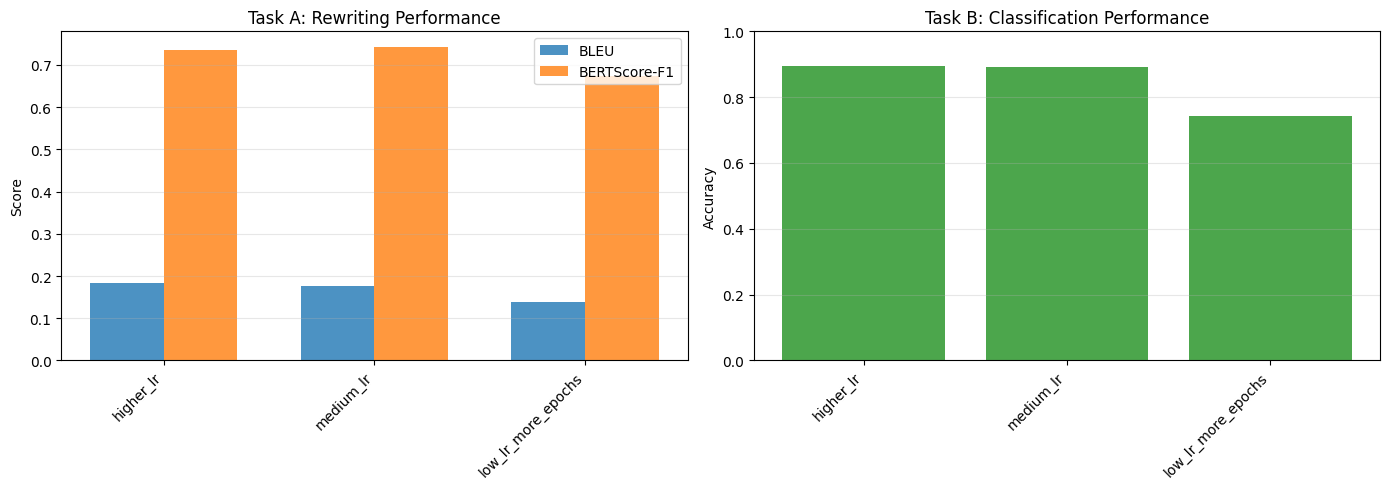

In [14]:
cfg_names = [r['config']['name'] for r in results_multitask]
bleu_scores = [r['bleu'] for r in results_multitask]
bert_scores = [r['bertscore_f1'] for r in results_multitask]
acc_scores = [r['accuracy'] for r in results_multitask]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x = np.arange(len(cfg_names))
width = 0.35

axes[0].bar(x - width / 2, bleu_scores, width, label='BLEU', alpha=0.8)
axes[0].bar(x + width / 2, bert_scores, width, label='BERTScore-F1', alpha=0.8)
axes[0].set_xticks(x)
axes[0].set_xticklabels(cfg_names, rotation=45, ha='right')
axes[0].set_ylabel('Score')
axes[0].set_title('Task A: Rewriting Performance')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

axes[1].bar(cfg_names, acc_scores, color='green', alpha=0.7)
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Task B: Classification Performance')
axes[1].set_xticklabels(cfg_names, rotation=45, ha='right')
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim(0, 1.0)

plt.tight_layout()
plt.show()

In [16]:
best_multitask = max(results_multitask, key=lambda x: x['bertscore_f1'])

comparison_data = [
    {'Model': 'T5 (Task 1)', 'Config': 'higher_lr',
     'BLEU': 0.0152, 'BERTScore': 0.6203, 'Accuracy': '-'},
    {'Model': 'FLAN-T5 (Task 1)', 'Config': 'medium_lr',
     'BLEU': 0.1948, 'BERTScore': 0.7568, 'Accuracy': '-'},
    {'Model': 'T5 (Task 2 - Single Rewrite)', 'Config': 'higher_lr',
     'BLEU': 0.2240, 'BERTScore': 0.7625, 'Accuracy': '-'},
    {'Model': 'T5 (Task 3 - Multi-task)', 'Config': best_multitask['config']['name'],
     'BLEU': best_multitask['bleu'], 'BERTScore': best_multitask['bertscore_f1'],
     'Accuracy': best_multitask['accuracy']}
]

comparison_df = pd.DataFrame(comparison_data)
comparison_df['BLEU'] = comparison_df['BLEU'].apply(lambda x: f"{x:.4f}" if isinstance(x, float) else x)
comparison_df['BERTScore'] = comparison_df['BERTScore'].apply(lambda x: f"{x:.4f}" if isinstance(x, float) else x)
comparison_df['Accuracy'] = comparison_df['Accuracy'].apply(lambda x: f"{x:.4f}" if isinstance(x, float) else x)

print(comparison_df.to_string(index=False))

                       Model    Config   BLEU BERTScore Accuracy
                 T5 (Task 1) higher_lr 0.0152    0.6203        -
            FLAN-T5 (Task 1) medium_lr 0.1948    0.7568        -
T5 (Task 2 - Single Rewrite) higher_lr 0.2240    0.7625        -
    T5 (Task 3 - Multi-task) medium_lr 0.1759    0.7423   0.8911


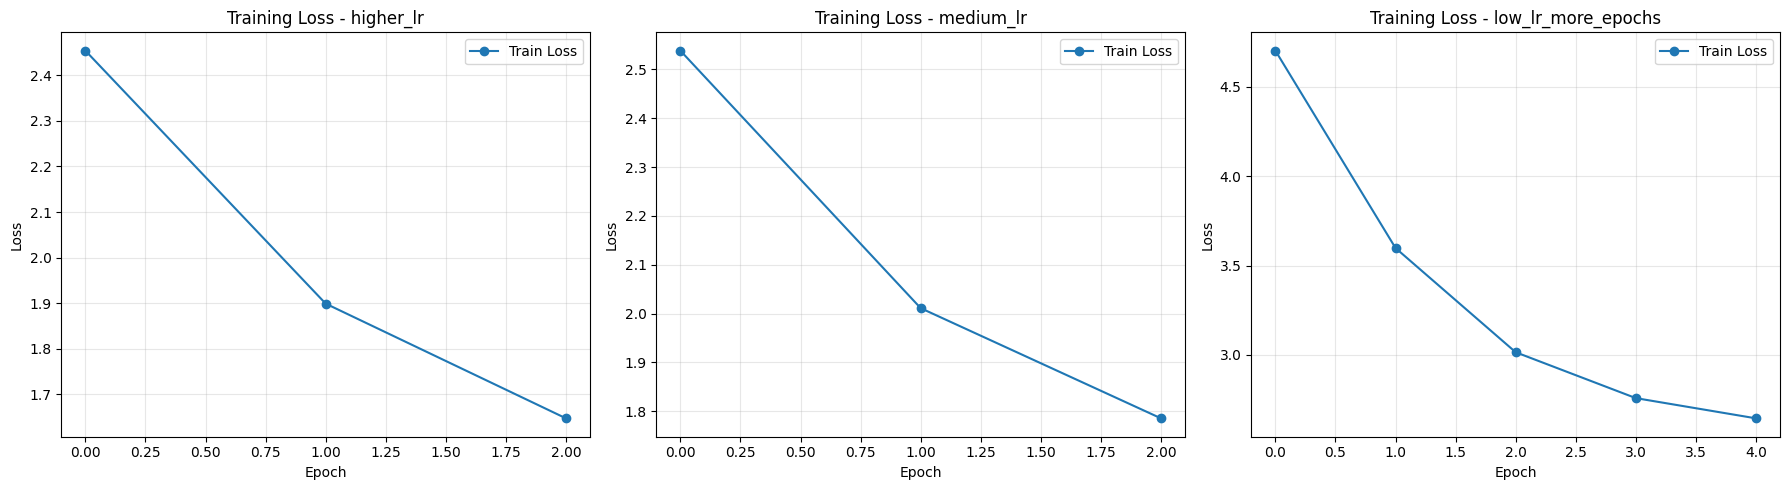

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, result in enumerate(results_multitask):
    history = result['history']
    cfg_name = result['config']['name']

    axes[i].plot(history['train_loss'], label='Train Loss', marker='o')
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Loss')
    axes[i].set_title(f'Training Loss - {cfg_name}')
    axes[i].legend()
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()